In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
#PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release-20160523/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup/:/scratch/SuperResolution/BRAINSSuperResolution/HCPWorkflows/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

In [3]:
from ReadWriteNrrdDWI import ReadNAMICDWIFromNrrd, WriteNAMICDWIToNrrd

In [4]:
inDWI='/Volumes/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_delme/DWI_corrected_alignedSpace.nrrd'

In [5]:
dwi_data,dwi_header,bvecs,bvals,gradient_index = ReadNAMICDWIFromNrrd(inDWI)

In [7]:
print(dwi_data.shape)
dwi_data = np.transpose(dwi_data,(1, 2, 3, 0))
print(dwi_data.shape)

(108, 145, 174, 145)
(145, 174, 145, 108)


In [8]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

from dipy.reconst.dti import TensorModel
ten = TensorModel(gtab)

tenfit_nos = ten.fit(dwi_data)

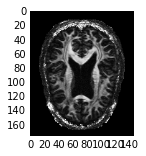

In [9]:
fa_nos = tenfit_nos.fa
fa_nos = np.transpose(fa_nos,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK

FA_nos = sitk.GetImageFromArray(fa_nos)
myshow(FA_nos)
sitk.WriteImage(FA_nos,'/raid0/homes/aghayoor/Desktop/fa_nos.nrrd')

In [10]:
def ScaleDWI(dwi_data, factor):
    scaled_dwi_data = dwi_data * factor
    return scaled_dwi_data

# scale by 0.1

In [11]:
dwi_data_half = ScaleDWI(dwi_data, 0.1)
tenfit_half = ten.fit(dwi_data_half)

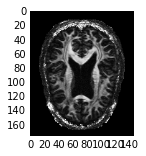

In [12]:
fa_half = tenfit_half.fa
fa_half = np.transpose(fa_half,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK

FA_half = sitk.GetImageFromArray(fa_half)
myshow(FA_half)
sitk.WriteImage(FA_half,'/raid0/homes/aghayoor/Desktop/fa_half.nrrd')

# scale by 10

In [13]:
dwi_data_two = ScaleDWI(dwi_data, 10)
tenfit_two = ten.fit(dwi_data_two)

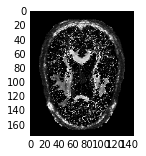

In [14]:
fa_two = tenfit_two.fa
fa_two = np.transpose(fa_two,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK

FA_two = sitk.GetImageFromArray(fa_two)
myshow(FA_two)
sitk.WriteImage(FA_two,'/raid0/homes/aghayoor/Desktop/fa_two.nrrd')

In [16]:
print(np.amax(fa_nos))
print(np.amin(fa_nos))
print(np.mean(fa_nos))
print('----------------')
print(np.amax(fa_half))
print(np.amin(fa_half))
print(np.mean(fa_half))
print('----------------')
print(np.amax(fa_two))
print(np.amin(fa_two))
print(np.mean(fa_two))

0.999999053186
0.0
0.090232496883
----------------
0.999999053186
0.0
0.090232496885
----------------
0.999999636763
0.0
0.0815940010189


In [18]:
print(np.amax(dwi_data))
print(np.amin(dwi_data))
print(np.mean(dwi_data))
print(dwi_data.shape)

32374
0
336.401464569
(145, 174, 145, 108)


In [20]:
print(np.amax(dwi_data_half))
print(np.amin(dwi_data_half))
print(np.mean(dwi_data_half))
print(dwi_data_half.shape)

3237.4
0.0
33.6401464569
(145, 174, 145, 108)


In [21]:
print(np.amax(dwi_data_two))
print(np.amin(dwi_data_two))
print(np.mean(dwi_data_two))
print(dwi_data_two.shape)

32764
-32768
1836.54082842
(145, 174, 145, 108)


# Normalize between zero and 1

In [23]:
# Normalize DWI scan components between zero and one
def NormalizeDWIComponents(dwi_data):
    def _3DNormalizeBetweenZeroAndOne(arr):   
        newMax = 1.0
        newMin = 0.0
        oldMax = float(np.amax(arr))
        oldMin = float(np.amin(arr))
        f=(newMax-newMin)/(oldMax-oldMin)
        normalized_arr = (arr-oldMin)*f+newMin
        return normalized_arr
    #
    dwi_data_f = dwi_data.astype(np.float32)
    numOfComponents = dwi_data_f.shape[3]
    for idx in range(numOfComponents):
        dwi_3d = dwi_data_f[:,:,:,idx]
        dwi_3d_norm = _3DNormalizeBetweenZeroAndOne(dwi_3d)
        dwi_data_f[:,:,:,idx] = dwi_3d_norm
    return dwi_data_f

In [24]:
dwi_data_norm = NormalizeDWIComponents(dwi_data)

In [25]:
print(np.amax(dwi_data_norm))
print(np.amin(dwi_data_norm))
print(np.mean(dwi_data_norm))
print(dwi_data_norm.shape)

1.0
0.0
0.0621098
(145, 174, 145, 108)


In [26]:
tenfit_norm = ten.fit(dwi_data_norm)

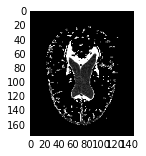

In [27]:
fa_norm = tenfit_norm.fa
fa_norm = np.transpose(fa_norm,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK

FA_norm = sitk.GetImageFromArray(fa_norm)
myshow(FA_norm)
sitk.WriteImage(FA_norm,'/raid0/homes/aghayoor/Desktop/fa_norm.nrrd')

In [28]:
## Test new baseline

In [29]:
inDWI='/Volumes/scratch/TESTS/IpythonNotebook/20160615_HCPWF/2_SRWF/DWI_Baseline.nrrd'

In [30]:
dwi_data,dwi_header,bvecs,bvals,gradient_index = ReadNAMICDWIFromNrrd(inDWI)

In [31]:
print(dwi_data.shape)

(145, 174, 145, 108)


In [32]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

from dipy.reconst.dti import TensorModel
ten = TensorModel(gtab)

tenfit_base = ten.fit(dwi_data)

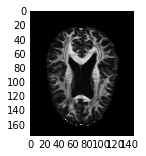

In [33]:
fa_base = tenfit_base.fa
fa_base = np.transpose(fa_base,(2, 1, 0)) # the reason is inconsistency between index order in numpy and ITK

FA_base = sitk.GetImageFromArray(fa_base)
myshow(FA_base)